In [4]:
from statistics import mean, StatisticsError

from trout.stars import get_star, STAR_START, STAR_END
from trout.nights import bad_nights

import matplotlib.pyplot as plt
import numpy as np

In [5]:
def get_mean_flux(data):
    """
    Calculate mean flux for given datapoint ignoring 
    any zero values in datapoint
    Assumes that the data is in the format 
    return from get_star().select
    """
    fluxes = map(lambda x : x[1], data)
    # Filter out the zeros
    return mean(filter(lambda x : x > 0, fluxes))

In [6]:
def analyze_star(star_no, data_dict, base_year, delta_years):
    query_base_year = (f"date >= '{base_year}-01-01' and " + 
                f"date < '{base_year + delta_years}-01-01'")
    query_top_year = (f"date >= '{base_year + delta_years}-01-01' "+
                       f" and date < '{base_year + delta_years + 1}-01-01'")
    
    star = get_star(star_no)
    
    star.select(query_base_year)
    mean_2011 = get_mean_flux(star.selected_data)
    
    star.select(query_top_year)
    mean_2012 = get_mean_flux(star.selected_data)
    
    # Store data in the the Dict data by star_no as key and
    # tuple of results as value. 
    data_dict[star_no] = (mean_2011, mean_2012)

In [7]:
def start_analysis(data_dict, 
                   base_year, 
                   delta_years, 
                   include_star = lambda x : True, 
                   quiet=False):
    
    for i in range(STAR_START, STAR_END):
        # Include the star for analysis if include_star(star_num)
        # returns true
        if not include_star(i):
            continue
        try:
            analyze_star(i, data_dict, base_year, delta_years)
        except StatisticsError as e:
            # We might get statistics error when trying 
            # to find mean of empty dataset
            continue
        # Print some indication as data is being processed
        if not quiet: 
            if i % 200 == 0 : print(f"Moving to {i}th star")
                
    if not quiet: print('Done\n')

In [8]:
# Calculate the increase % from 2011 to 2012 ignoring
# datapoints for stars whose data isn't present in both years
def calculate_difference(data_dict, difference_data):
    for star_no in data_dict.keys():
        mean_from_year, mean_to_year = data_dict[star_no]
        # Ignore stars with partial attendance
        if mean_from_year <= 0 or mean_to_year <= 0:
            continue
        difference_data[star_no] = (
            (mean_to_year - mean_from_year) / mean_from_year) * 100

In [9]:
# Calcualte statistics of difference data
def show_difference_stats(difference_data):
    differences = np.array(list(difference_data.values()))
    mean_diff, median_diff, std_diff = (np.mean(differences), 
                                        np.median(differences), 
                                        np.std(differences))
    min_diff, max_diff = np.min(differences), np.max(differences)

    print(f"Mean increase %", mean_diff)
    print(f"Median increase %", median_diff)
    print(f"Standard deviation of increase %", std_diff)
    print(f"Min increase %", min_diff)
    print(f"Max increase %", max_diff)


In [10]:
# Plot results of Increase percentage for stars in given range
def show_increase_precentage(difference_data,
                             base_year,
                             delta_years,
                             min_star=STAR_START, 
                             max_star=STAR_END):
    number_difference_list = difference_data.items()
    # Filer stars
    lists = list(filter(lambda x : 
                        min_star <= x[0] <= max_star, 
                        number_difference_list))
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x, y, 'b+')
    plt.xlabel('Star #')
    plt.ylabel('% Inc')
    plt.title(f'% Increase from {base_year} ' 
              + f'to {base_year + delta_years}')
    plt.show()

In [11]:
def analyze_step(base_year, 
                 delta_years, 
                 include_star=lambda x : True,
                 quiet=False, 
                 show_chart=True,
                ):

    # These dictionaries will be mutated after analysis
    data = {}
    data_difference = {}
    
    if not quiet:
        print(f'===========Step Analysis {base_year}' + 
              f' to {base_year + delta_years}===========')
    
    # Calculation
    start_analysis(data, 
                   base_year, 
                   delta_years, 
                   include_star=include_star, 
                   quiet=quiet)
    calculate_difference(data, data_difference)
    
    if not quiet:
        print('======Stats======')
        show_difference_stats(data_difference)
        print('=================')
    
    # Chart
    if show_chart:
        show_increase_precentage(data_difference, base_year, delta_years)
    
    return data, data_difference

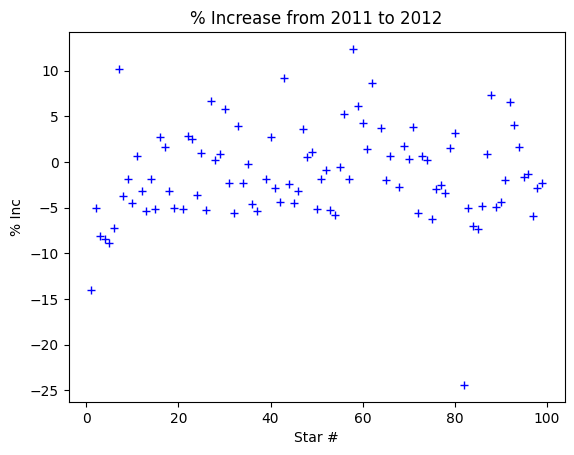

In [13]:
d, dd = analyze_step(2011, 1, lambda x : x < 100, quiet=True)

In [ ]:
base_years = [
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2019,
 2020]

for year in base_years:
    analyze_step(year, 1, True)